In [1]:
import json, os, random, statistics, matplotlib
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from datetime import datetime
import seaborn as sns

## Load Data

In [2]:
experts = pd.read_csv('twitter_accounts.csv')
updated_dict = json.load(open('cleaned_account_info.json')) 
follower = json.load(open('cleaned_follower.json'))
following = json.load(open('cleaned_following.json'))
experts_dict = dict(zip(experts['twitter'], experts['institution']))

In [3]:
G, attrs = nx.DiGraph(), dict()
for user in updated_dict:
    G.add_node(user)
    attrs[user] = dict()
    if user in experts_dict: user_class = experts_dict[user]
    else: 
        try: user_class = updated_dict[user]['type']
        except TypeError: continue
    attrs[user]['class'] = user_class
    attrs[user]['follower'] = updated_dict[user]['follower']
    attrs[user]['following'] = updated_dict[user]['following']
nx.set_node_attributes(G, attrs)

In [4]:
for user in follower:
    for from_node in follower[user]:
        G.add_edge(from_node, user)
for user in following:
    for to_node in following[user]:
        G.add_edge(user, to_node)

## Think Tank Specific Network

In [17]:
def gini(x):
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [18]:
def draw_origanization_graphs(data, tag, name, method):
    
    if method == 'Eigenvector': 
        centrality = nx.eigenvector_centrality(H)
        factor = 500    
    if method == 'Closeness': 
        centrality = nx.closeness_centrality(H)
        factor = 500
    if method == 'Betweenness': 
        centrality = nx.betweenness_centrality(H)
        factor = 10000
    if method == 'Indegree':
        centrality = nx.in_degree_centrality(H)
        factor = 500
    if method == 'Pagerank':
        centrality = nx.pagerank(H)
        factor = 1500
    
    print(gini(list(centrality.values())))
    #sns.distplot(list(centrality.values()))
    
    plt.figure(figsize=(8,6))
    for color, gp in enumerate(groups):
        agents = list(data[data[cat]==gp]['twitter'])
        agents = [i for i in agents if (i in H.nodes())]
        nx.draw_networkx_nodes(H, pos, nodelist= agents,
                           node_color = [cmap(norm(color)) for i in agents], 
                           node_size= [centrality[i]*factor for i in agents],
                           alpha=0.8, label = gp)

    nx.draw_networkx_edges(H, pos, width=1.0,alpha=0.01, color = 'grey')
    lgnd = plt.legend()
    for handle in lgnd.legendHandles: handle.set_sizes([20])
    plt.title(f'{name} {method} Centrality Twitter Network')
    plt.show()

In [19]:
data = pd.read_csv('expert_twitters/aei_twitter.csv')
tag = 'aei'
name = 'American Enterprise Institute'
data['position'] = data['position'].apply(lambda x: x.lower())

#data = pd.read_csv('expert_twitters/heritage_twitter.csv')
#tag = 'heritage'
#name = 'Heritage'
#n = 6

#data = pd.read_csv('expert_twitters/brookings_twitter.csv')
#tag = 'brookings'
#name = 'Brookings'

In [21]:
cat = 'position'
data = data[~data['twitter'].isna()]
data = data[~data[cat].isna()]
category = dict(zip(data['twitter'], data[cat]))
labels = nx.get_node_attributes(G, 'class') 
tar_twitters = list(data['twitter'])
tar_labels = {i:labels[i] for i in labels if (labels[i] in [tag]) and (i in tar_twitters)}
H = G.subgraph(tar_labels).copy()

deg_cent = nx.degree_centrality(H)
#exclude = sorted(deg_cent.items(), key=lambda x: -x[1])[-n:]
exclude = [i for i in deg_cent if deg_cent[i]< 0.08]
#print(exclude)
for i in exclude: H.remove_node(i)

groups = set(data[cat].dropna())
mapping = dict(zip(sorted(groups), range(len(groups))))
colors = [mapping[category[n]] for n in H.nodes()]

cmap = matplotlib.cm.get_cmap('Set1')
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(groups))

pos = nx.spring_layout(H)

0.657435340547486


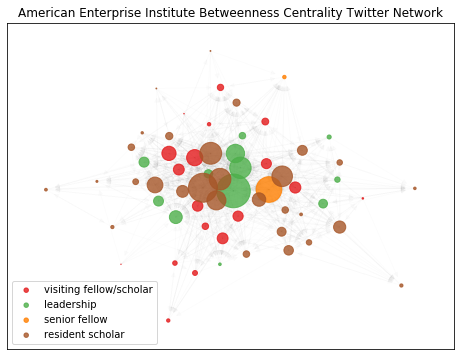

In [22]:
draw_origanization_graphs(data, tag, name, 'Betweenness')

0.3462825594127354


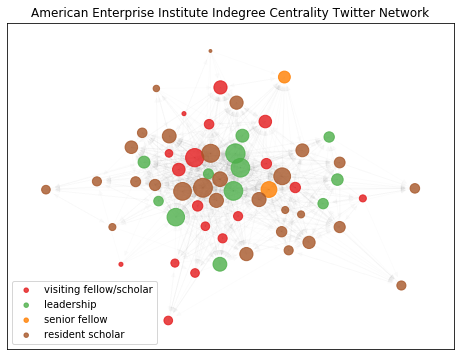

In [24]:
draw_origanization_graphs(data, tag, name, 'Indegree')

## Draw Think Tank Network

In [5]:
labels = nx.get_node_attributes(G, 'class') 
tags = ['aei', 'heritage', 'brookings']
tar_labels = {i:labels[i] for i in labels if labels[i] in tags}
H = G.subgraph(tar_labels).copy()
groups = set(nx.get_node_attributes(H,'class').values())
len(H.nodes)

412

In [180]:
## Ignore: a previous attempt to visualize all nodes
pos_grids = dict()
for key in groups:
    num = len([i for i in tar_labels if tar_labels[i] == key])
    if key == 'aei': center = [(0,10)]
    elif key == 'heritage': center = [(0, 0)]
    elif key == 'brookings': center = [(0, -10)]
    elif key == 'government_agency': center = [(-6, 5)]
    elif key == 'news_outlet': center = [(-6, -5)]
    elif key == 'house115': center = [(6, 10)]
    elif key == 'senate115': center = [(6, 5)]
    elif key == 'rep116': center = [(6, -5)]
    elif key == 'sen116': center = [(6, -10)]
    X, y = make_blobs(n_samples=num, centers=center, shuffle=False, random_state=42)
    pos_grids[key] = dict()
    pos_grids[key]["pos"] = X
    pos_grids[key]["count"] = 0

In [7]:
## Ignore: I tried to force nodes to cluster based on institutions
## and then realized they naturally cluster as such.
pos_grids = dict()
for key in groups:
    num = len([i for i in tar_labels if tar_labels[i] == key])
    if key == 'aei': center = [(-5,5)]
    elif key == 'heritage': center = [(5, 5)]
    elif key == 'brookings': center = [(0, 0)]
    
    X, y = make_blobs(n_samples=num, centers=center, shuffle=False, random_state=42)
    pos_grids[key] = dict()
    pos_grids[key]["pos"] = X
    pos_grids[key]["count"] = 0

pos = {}
for i in H.nodes():
    key = tar_labels[i]
    num = pos_grids[key]["count"]
    pos[i] = pos_grids[key]["pos"][num]
    pos_grids[key]["count"] += 1  

In [6]:
##  size
bb = nx.betweenness_centrality(H)
#bb = nx.out_degree_centrality(H)
exclude = [i for i in bb if bb[i] < 0.000005]
for node in exclude: H.remove_node(node)
nx.set_node_attributes(H, bb, 'betweenness')
print(len(H.nodes()))

370


In [14]:
pos = nx.spring_layout(H)
labels = nx.get_node_attributes(H, 'class') 
tar_labels = {i:labels[i] for i in labels if labels[i] in groups}
mapping = dict(zip(sorted(groups), range(len(groups))))
#colors = [mapping[labels[n]] for n in H.nodes()]
cmap = matplotlib.cm.get_cmap('Accent')
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(groups))

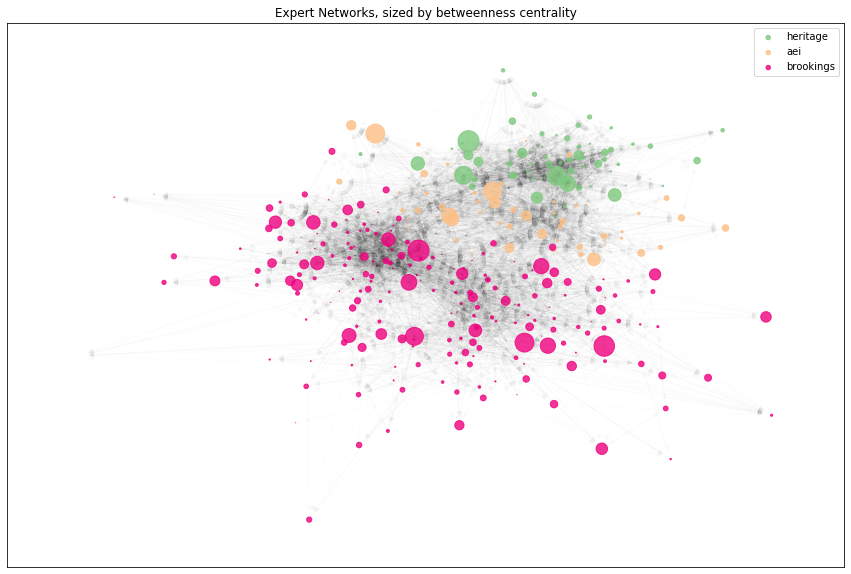

In [16]:
plt.figure(figsize=(15,10))
for color, gp in enumerate(groups):
    agents = [i for i in labels if labels[i] == gp]
    nx.draw_networkx_nodes(H, pos, nodelist = agents,
                           node_color = [cmap(norm(color)) for i in agents], 
                           node_size= [bb[i]*10000 for i in bb],
                           alpha=0.8, label = gp)
nx.draw_networkx_edges(H, pos, width=1.0,alpha=0.01, color = 'grey')
lgnd = plt.legend()
for handle in lgnd.legendHandles: handle.set_sizes([20])
    
plt.title('Expert Networks, sized by betweenness centrality')
plt.show()